In [49]:
import generax as gx
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from generax.training.trainer import Trainer
import generax.util as util
from functools import partial

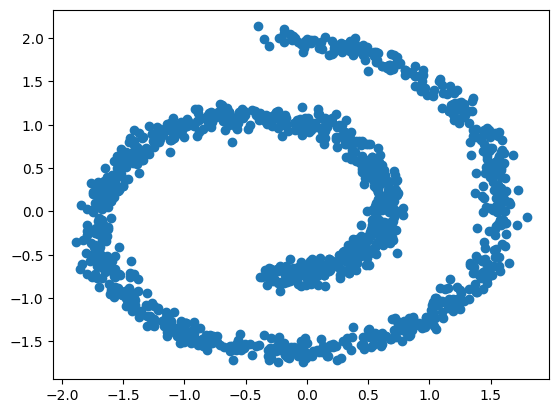

In [57]:
# Get the dataset
from sklearn.datasets import make_moons, make_swiss_roll
data, y = make_swiss_roll(n_samples=100000, noise=0.5)
data = data[:, [0, 2]]
data = data - data.mean(axis=0)
data = data/data.std(axis=0)
key = random.PRNGKey(0)

def get_train_ds(key, batch_size: int = 128):
  total_choices = jnp.arange(data.shape[0])
  closed_over_data = data # In case we change the variable "data"
  while True:
    key, _ = random.split(key, 2)
    idx = random.choice(key,
                        total_choices,
                        shape=(batch_size,),
                        replace=True)
    yield dict(x=closed_over_data[idx])

train_ds = get_train_ds(key)

true_samples = util.extract_multiple_batches_from_iterator(train_ds,
                                                   n_batches=10,
                                                   single_batch=True)
plt.scatter(*true_samples['x'].T)

In [58]:
x = data[:10]

from generax.distributions.flow_models import RealNVP, NeuralSpline, ContinuousNormalizingFlow

model = ContinuousNormalizingFlow(input_shape=x.shape[1:],
                                  key=key,
                                  n_blocks=5,
                                  hidden_size=32,
                                  working_size=16,
                                  time_embedding_size=32,
                                  n_time_features=4*32,
                                  controller_atol=1e-7,
                                  controller_rtol=1e-7)

In [59]:
from generax.training import FlowMatching
import optax

# Create the optimizer
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0,
                                   peak_value=1.0,
                                   warmup_steps=1000,
                                   decay_steps=3e5,
                                   end_value=0.1,
                                   exponent=1.0)
chain = []
chain.append(optax.clip_by_global_norm(15.0))
chain.append(optax.adamw(1e-3))
chain.append(optax.scale_by_schedule(schedule))
optimizer = optax.chain(*chain)

# Create the loss function
fm = FlowMatching(path_type='straight',
                  coupling_type='ot')

# Data dependent initialization for the vector field
data = next(train_ds)
model = fm.initialize_vector_field(model, data, key)

# Create the trainer
trainer = Trainer(checkpoint_path='tmp/flow_matching')
model = trainer.train(model=model,
                      objective=fm.loss_function,
                      evaluate_model=lambda x: x,
                      optimizer=optimizer,
                      num_steps=20000,
                      double_batch=1000,
                      data_iterator=train_ds,
                      checkpoint_every=1000,
                      test_every=-1,
                      retrain=False)

loss: 0.1275:  10%|█         | 2000/20000 [00:36<05:25, 55.23it/s]

Checkpointed model


loss: 0.1218:  15%|█▌        | 3000/20000 [00:49<04:27, 63.47it/s]

Checkpointed model


loss: 0.1207:  20%|██        | 4000/20000 [01:02<03:53, 68.61it/s]

Checkpointed model


loss: 0.1211:  25%|██▌       | 5000/20000 [01:15<03:30, 71.40it/s]

Checkpointed model


loss: 0.1191:  30%|███       | 6000/20000 [01:27<03:09, 73.76it/s]

Checkpointed model


loss: 0.1199:  35%|███▌      | 7000/20000 [01:40<02:52, 75.21it/s]

Checkpointed model


loss: 0.1184:  40%|████      | 8000/20000 [01:53<02:37, 75.99it/s]

Checkpointed model


loss: 0.1196:  45%|████▌     | 9008/20000 [02:06<02:24, 75.86it/s]

Checkpointed model


loss: 0.1182:  50%|█████     | 10008/20000 [02:19<02:11, 76.23it/s]

Checkpointed model


loss: 0.1181:  55%|█████▌    | 11008/20000 [02:31<01:55, 77.96it/s]

Checkpointed model


loss: 0.1196:  60%|██████    | 12008/20000 [02:43<01:40, 79.21it/s]

Checkpointed model


loss: 0.1188:  65%|██████▌   | 13008/20000 [02:56<01:27, 80.02it/s]

Checkpointed model


loss: 0.1179:  70%|███████   | 14008/20000 [03:08<01:14, 80.44it/s]

Checkpointed model


loss: 0.1170:  75%|███████▌  | 15008/20000 [03:20<01:01, 80.78it/s]

Checkpointed model


loss: 0.1177:  80%|████████  | 16008/20000 [03:32<00:49, 81.11it/s]

Checkpointed model


loss: 0.1153:  85%|████████▌ | 17008/20000 [03:45<00:36, 81.49it/s]

Checkpointed model


loss: 0.1169:  90%|█████████ | 18008/20000 [03:57<00:24, 81.70it/s]

Checkpointed model


loss: 0.1171:  95%|█████████▌| 19008/20000 [04:09<00:12, 81.86it/s]

Checkpointed model


loss: 0.1174:   0%|          | 20/20000 [04:21<72:33:33, 13.07s/it]

Checkpointed model


In [60]:
samples = model.sample(key, n_samples=1000)

In [70]:
T = 5
ts = jnp.linspace(0.0, 1.0, T)

def get_time_samples(z):
  log_pz = model.prior.log_prob(z)
  x, log_det = model.transform.neural_ode(z,
                                    inverse=True,
                                    log_likelihood=True,
                                    save_at=ts)
  log_px = log_pz - log_det
  return x, log_px

z = random.normal(key, (10000, 2))
samples, log_px = jax.vmap(get_time_samples)(z)
samples.shape

(10000, 5, 2)

In [71]:
log_px.shape

(10000, 5)

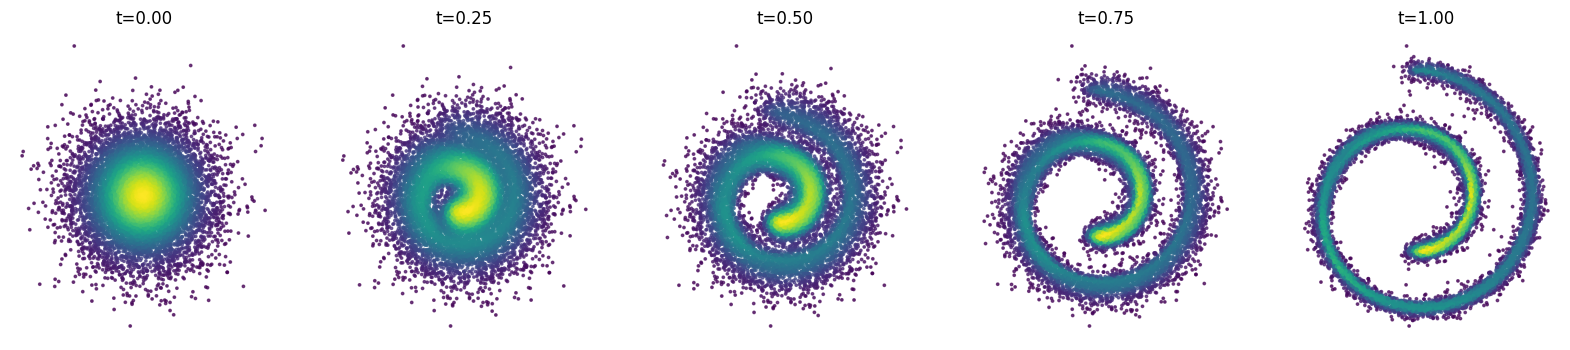

In [73]:
n_rows, n_cols = 1, T
size = 4
fig, axes = plt.subplots(1, T, figsize=(n_cols*size, n_rows*size))
ax_iter = iter(axes.ravel())
for i, t in enumerate(ts):
  ax = next(ax_iter)
  ax.scatter(*samples[:, i].T, alpha=0.7, s=3, c=jnp.exp(log_px)[:, i])
  ax.set_title(f't={t:3.2f}')
  ax.set_axis_off()

import os
# Get the path for ~
home = os.path.expanduser("~")
save_dir = os.path.join(home, 'eddiecunningham.github.io', 'content', 'images')
save_path = os.path.join(save_dir, 'cnf_evolution.png')
plt.savefig(save_path, bbox_inches='tight')